In [23]:
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt 
from PIL import Image 

ct_path = '/home/PET-CT/splited_data_15k/train/A/1234.npy'
pet_path = '/home/PET-CT/splited_data_15k/train/B/1234.npy'

In [24]:
from model.BrownianBridge.LatentBrownianBridgeModel import LatentBrownianBridgeModel
import yaml
import argparse
import omegaconf 
import torch
import torchvision.transforms as transforms

f = open('/home/PET-CT/thaind/BBDM_folk/configs/UncerBBDM.yaml', 'r')
dict_config = yaml.load(f, Loader=yaml.FullLoader)

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict) or isinstance(value, omegaconf.dictconfig.DictConfig):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

nconfig = dict2namespace(dict_config)
ltbbdm = LatentBrownianBridgeModel(nconfig.model)

load Unet1 from ./results/123_UncerBBDM_1Unet_confloss_15k/LBBDM-f4/checkpoint/top_model_epoch_108.pth
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
Restored from /home/PET-CT/vqgan/vq1_3_69.ckpt
load vqgan from /home/PET-CT/vqgan/vq1_3_69.ckpt


((512, 512), -2000, 2319)

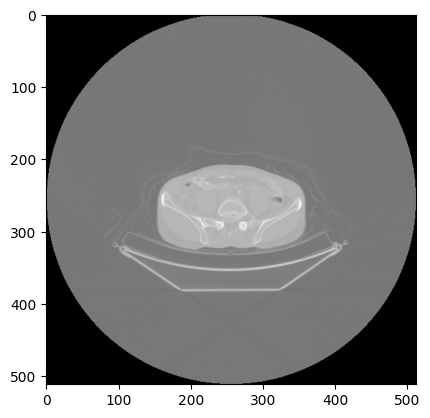

In [25]:
ct_img = np.load(ct_path, allow_pickle=True) 
plt.imshow(ct_img, cmap='gray')

ct_img.shape

ct_img.shape, ct_img.min(), ct_img.max()

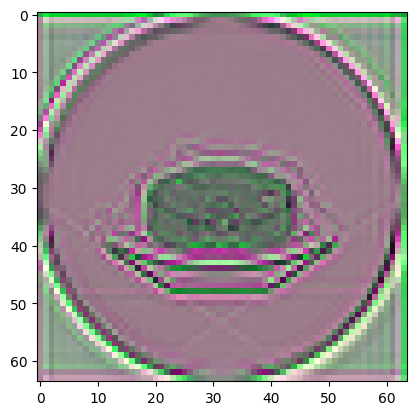

In [26]:
x = ct_img / 2047.
x = Image.fromarray(x)

image = transform(x) 
image = (image - 0.5) * 2.
image = image.unsqueeze(0)

latent = ltbbdm.encode(image)
latent = (latent / 2. + 0.5).clamp(0., 1.)

latent_np = latent.squeeze().permute(1, 2, 0).cpu().numpy()
latent_np = latent_np * 255.
latent_np = latent_np.astype(np.uint8)

plt.imshow(latent_np)

latent_np.min(), latent_np.max()

ct_img = latent_np[:, :, 0]

((256, 256), 0, 32766)

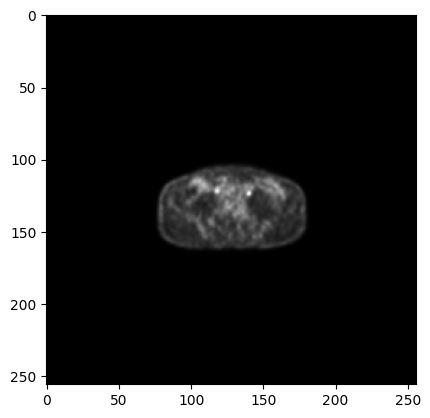

In [27]:
pet_img = np.load(pet_path, allow_pickle=True) 

plt.imshow(pet_img, cmap='gray')

pet_img.shape, pet_img.min(), pet_img.max()

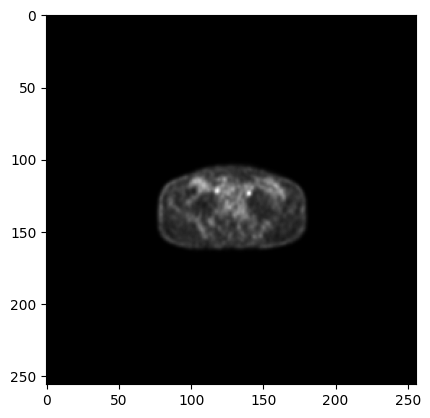

In [28]:
pet_img = pet_img / 32767. * 255.
pet_img = pet_img.astype(np.uint8)

plt.imshow(pet_img, cmap='gray')

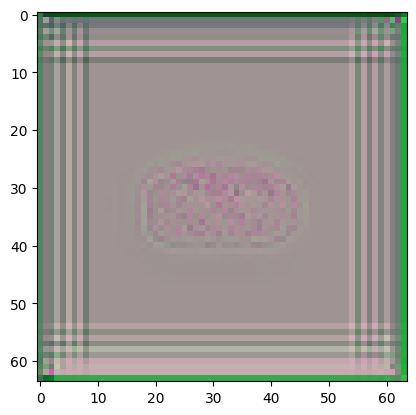

In [29]:
x = pet_img / 32767.
x = Image.fromarray(x)

image = transform(x) 
image = (image - 0.5) * 2.
image = image.unsqueeze(0)

latent = ltbbdm.encode(image)
latent = (latent / 2. + 0.5).clamp(0., 1.) * 255.

latent_np = latent.squeeze().permute(1, 2, 0).cpu().numpy()
latent_np = latent_np.astype(np.uint8)

plt.imshow(latent_np)

latent_np.min(), latent_np.max()

pet_img = latent_np[:, :, 0]

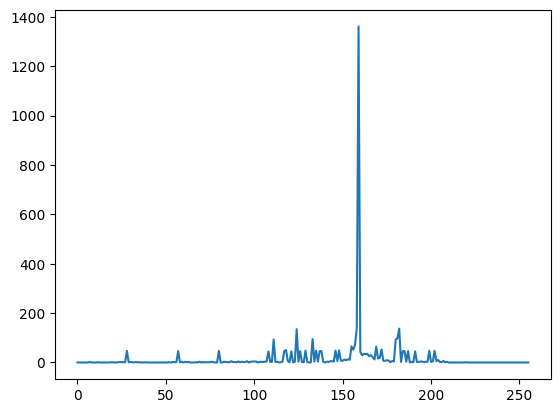

In [30]:
ret, thresh = cv.threshold(pet_img, 0, 255, 0)
img_hist = cv.calcHist([pet_img],channels=[0], mask=thresh, histSize=[256], ranges=[0, 255])
plt.plot(img_hist)

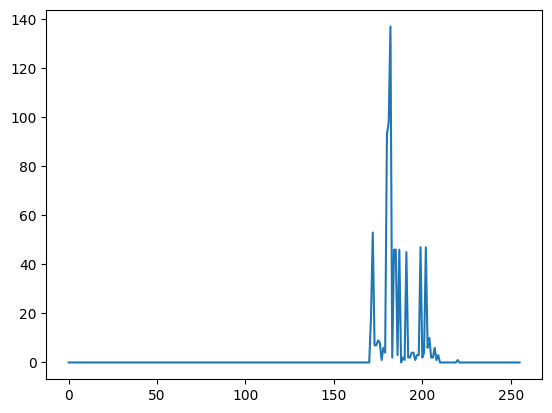

In [31]:
ret, thresh = cv.threshold(pet_img, 170, 255, 0)
img_hist = cv.calcHist([pet_img],channels=[0], mask=thresh, histSize=[256], ranges=[0, 255])
plt.plot(img_hist)

(0, 255)

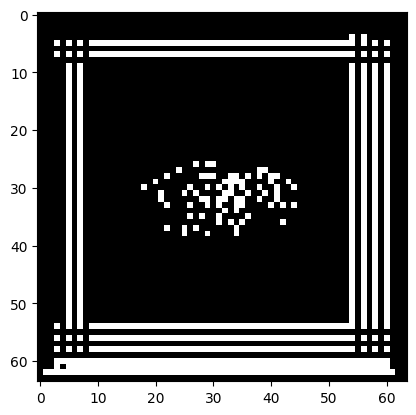

In [32]:
STATIC_THRESH_HOLD = 170
MAX_THRESH_HOLD = 190
ret, thresh = cv.threshold(pet_img, STATIC_THRESH_HOLD, 255, 0)

plt.imshow(thresh, cmap='gray')

thresh.min(), thresh.max()

(0, 220)

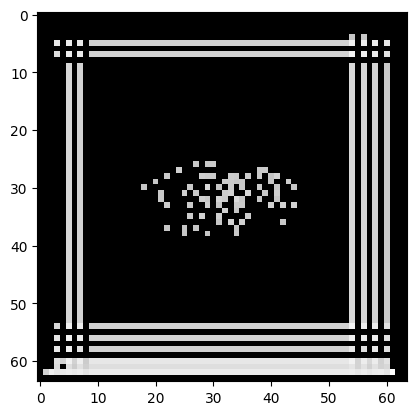

In [33]:
mask = thresh / 255.
mask = mask.astype(np.uint8)

img_mask = cv.bitwise_and(pet_img, pet_img, mask=mask)

plt.imshow(img_mask, cmap='gray')

img_mask.min(), img_mask.max()

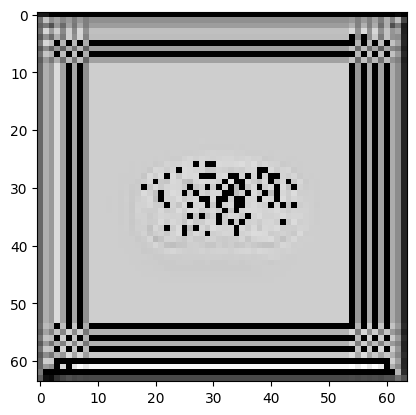

In [34]:
contours_img = pet_img.copy()

contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(contours_img, contours, contourIdx=-1, color=(0, 0, 0), thickness=1)

plt.imshow(contours_img, cmap='gray')

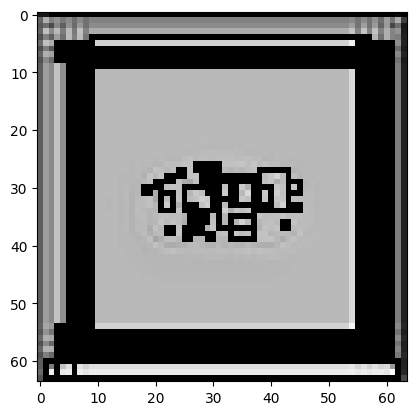

In [35]:
all_bounding_boxes_img = pet_img.copy()
all_bounding_boxes = []

for i in range(len(contours)):
    x, y, w, h = cv.boundingRect(contours[i])
    cv.rectangle(all_bounding_boxes_img, (x, y), (x + w, y + h), (0, 0, 0), 1)
    all_bounding_boxes.append((x, y, x + w, y + h))
    
plt.imshow(all_bounding_boxes_img, cmap='gray')

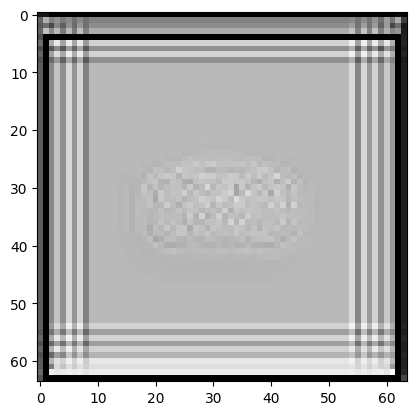

In [36]:
min_x = min(box[0] for box in all_bounding_boxes)
min_y = min(box[1] for box in all_bounding_boxes)
max_x = max(box[2] for box in all_bounding_boxes)
max_y = max(box[3] for box in all_bounding_boxes)

largest_bounding_box = (min_x, min_y, max_x - min_x, max_y - min_y)

largest_box_img = pet_img.copy()
x, y, w, h = largest_bounding_box

cv.rectangle(largest_box_img, (x, y), (x + w, y + h), (0, 0, 0), 1)

plt.imshow(largest_box_img, cmap='gray')

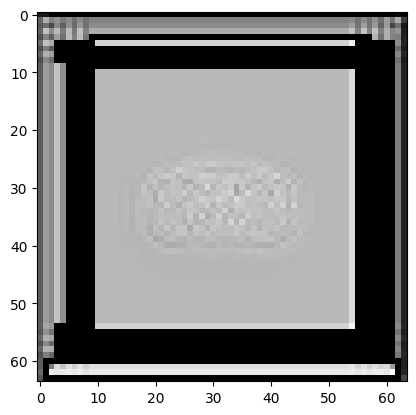

In [37]:
def are_boxes_overlapping(box1, box2):
    return not (box2[0] > box1[2] or box2[2] < box1[0] or box2[1] > box1[3] or box2[3] < box1[1])

sorted_boxes = sorted(all_bounding_boxes, key=lambda box: (box[2] - box[0]) * (box[3] - box[1]), reverse=True)

non_overlapping_boxes = [sorted_boxes[0]]

for current_box in sorted_boxes[1:]:
    if all(not are_boxes_overlapping(existing_box, current_box) for existing_box in non_overlapping_boxes):
        non_overlapping_boxes.append(current_box)

non_overlapping_boxes_img = pet_img.copy()
for box in non_overlapping_boxes:
    x, y, x2, y2 = box
    cv.rectangle(non_overlapping_boxes_img, (x, y), (x2, y2), (0, 0, 0), 1)

plt.imshow(non_overlapping_boxes_img, cmap='gray')

In [38]:
# import torchvision.transforms as transforms

# IMAGE_SIZE = 256

# transform = transforms.Compose([
#     transforms.Resize(IMAGE_SIZE),
#     transforms.ToTensor()
# ])

# ct_img = ct_img / 4095.0
# ct_img = ct_img / 2 + 0.5

# ct_img = Image.fromarray(ct_img)

# ct_img = transform(ct_img) 

# ct_img = ct_img.permute(1, 2, 0)

# ct_img = ct_img.numpy()

# plt.imshow(ct_img, cmap='gray')

# ct_img *= 255
# ct_img = ct_img.astype(np.uint8)

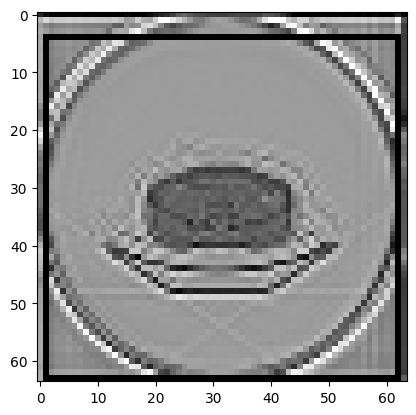

In [39]:
min_x = min(box[0] for box in all_bounding_boxes)
min_y = min(box[1] for box in all_bounding_boxes)
max_x = max(box[2] for box in all_bounding_boxes)
max_y = max(box[3] for box in all_bounding_boxes)

largest_bounding_box = (min_x, min_y, max_x - min_x, max_y - min_y)

largest_box_ct_img = ct_img.copy()
x, y, w, h = largest_bounding_box

cv.rectangle(largest_box_ct_img, (x, y), (x + w, y + h), (0, 0, 0), 1)

plt.imshow(largest_box_ct_img, cmap='gray')

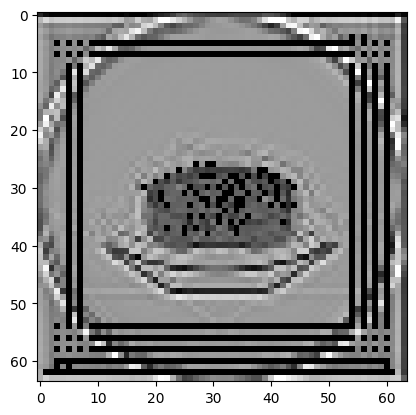

In [40]:
contours_ct_img = ct_img.copy()

contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(contours_ct_img, contours, contourIdx=-1, color=(0, 0, 0), thickness=1)

plt.imshow(contours_ct_img, cmap='gray')